In [1]:
import os
import mediapipe as mp 
import numpy as np
import cv2
import math
import pickle
import tensorflow as tf


## **1. Alphabet Landmarks**

---

In [2]:
list_of_metrics = {}

### Common Functions used:

In [2]:
def preprocess(data, labels):
    
    import tensorflow as tf
    from sklearn.model_selection import train_test_split

    # STEP 1: Data Distribution Check
    print("Data Shape: ", data.shape, "||  Label Shape: ", labels.shape)
    unique, counts = np.unique(labels, return_counts=True)
    print("\nOriginal Label Distribution:\n", dict(zip(unique, counts)))

    # STEP 2: Convert labels to a Categorical Variable
    lab = tf.keras.utils.to_categorical(labels)

    # STEP 3: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(data, lab, test_size=0.2, random_state=42)

    unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
    print("\nTraining:\n", X_train.shape, y_train.shape, "\n") #, dict(zip(unique, counts)))

    unique, counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
    print("Test:\n", X_test.shape, y_test.shape, "\n") #, dict(zip(unique, counts)))

    return X_train, X_test, y_train, y_test
        

In [3]:
def train_model(input_shape = (21,2), output_shape=24):
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

    model = Sequential([
        Flatten(input_shape=(input_shape[0], input_shape[1])),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(512, activation='relu'),
        Dropout(rate=0.1),
        Dense(512, activation='relu'),
        Dropout(rate=0.2),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(output_shape, activation='softmax'),
    ])

    # model.summary()

    callback_checkpoint = ModelCheckpoint(
        './checkpoints/', monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch',
    )
    callback_loss = EarlyStopping(monitor='loss', patience=4)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, 
                        epochs=50, 
                        callbacks=[callback_checkpoint, callback_loss])
    return model, history

In [4]:
def evaluate_model(history, X_test, y_test, model, title, actions):
  """
    Input: 
      history - Model history variable
      X_test - Test features
      y_test - Target test variables
      model - Keras Model 

    Output:
      Accuracy Plot (Training + Validation)
      Loss Plot (Training + Validation)
      Confusion matrix
      Accuracy
      Classification Report
  """  

  from sklearn.metrics import classification_report, confusion_matrix
  import matplotlib.pyplot as plt
  import seaborn as sns
  
  scores = model.evaluate((X_test),y_test, verbose=0)
  
  fig, axs = plt.subplots(1,3, figsize=(22,6))
  fig.tight_layout()

  axs[0].plot(history.history['accuracy'])
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_title('Model - Accuracy (' + title +")")
  axs[0].legend(['Training'], loc='lower right')

  axs[1].plot(history.history['loss'])
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Model Loss')
  axs[1].set_title('Model - Loss (' + title +")")
  axs[1].legend(['Training'], loc='upper right')

  target_names=actions
  
  y_true=[]
  for element in y_test:
      y_true.append(np.argmax(element))

  prediction_proba = model.predict(X_test)
  prediction = np.argmax(prediction_proba,axis=1)
  cnf_matrix = confusion_matrix(y_true, prediction)    
  g = sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt='g', ax=axs[2],
                  xticklabels=target_names, yticklabels=target_names)
  axs[2].set_title("Confusion Matrix")
  plt.show()


  print("\nAccuracy: %.2f%% \n" % (scores[1]*100))
  print(classification_report(y_true, prediction, target_names=target_names))

  return {"metrics": classification_report(y_true, prediction, target_names=target_names, output_dict=True)}

In [5]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [6]:
def get_distance(a,b):
    from math import pow, sqrt
    return round(sqrt(pow(b[0]-a[0],2) + pow(b[1]-a[1],2)), 4)

### Loading Landmarks and Labels

In [7]:
LANDMARK_PATH = os.path.join('./data/Character_Data_Landmarks')

actions = [chr(i) for i in range(ord('A'), ord('Z')) if chr(i)!='T']

no_sequences =  25
sequence_length = 30

print(actions)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y']


In [8]:
label_map = {label:num for num, label in enumerate(actions)}
print(label_map)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


<br>

### **a. Just (X,Y)**

In [9]:
missing = []
data = []
labels = []

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                landmarks = []
                for handslms in result:
                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        landmarks.append([lmx, lmy])
                
                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [10]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

Data Shape:  (17764, 21, 2) ||  Label Shape:  (17764,)

Original Label Distribution:
 {0: 747, 1: 748, 2: 746, 3: 748, 4: 749, 5: 749, 6: 605, 7: 718, 8: 748, 9: 746, 10: 749, 11: 749, 12: 750, 13: 749, 14: 749, 15: 748, 16: 731, 17: 748, 18: 750, 19: 745, 20: 746, 21: 748, 22: 749, 23: 749}

Training:
 (14211, 21, 2) (14211, 24) 

Test:
 (3553, 21, 2) (3553, 24) 



In [11]:
model_xy, history = train_model( (X_train.shape[1],X_train.shape[2]), y_train.shape[1])

Epoch 1/50
445/445 [==============================] - 3s 4ms/step - loss: 3.8166 - accuracy: 0.0413
Epoch 2/50
445/445 [==============================] - 2s 4ms/step - loss: 2.3667 - accuracy: 0.2460
Epoch 3/50
445/445 [==============================] - 2s 4ms/step - loss: 0.5821 - accuracy: 0.7808
Epoch 4/50
445/445 [==============================] - 2s 4ms/step - loss: 0.3127 - accuracy: 0.8888
Epoch 5/50
445/445 [==============================] - 2s 4ms/step - loss: 0.2683 - accuracy: 0.9115
Epoch 6/50
445/445 [==============================] - 2s 4ms/step - loss: 0.2070 - accuracy: 0.9371
Epoch 7/50
445/445 [==============================] - 2s 4ms/step - loss: 0.2423 - accuracy: 0.9255
Epoch 8/50
445/445 [==============================] - 2s 4ms/step - loss: 0.2016 - accuracy: 0.9358
Epoch 9/50
445/445 [==============================] - 2s 4ms/step - loss: 0.2007 - accuracy: 0.9362
Epoch 10/50
445/445 [==============================] - 2s 4ms/step - loss: 0.1874 - accuracy: 0.9439

In [13]:
model_xy.save("./model_saves/only_coordinates")

INFO:tensorflow:Assets written to: ./model_saves/only_coordinates\assets


In [48]:
from tensorflow.keras.models import load_model

model_xy = load_model("./model_saves/only_coordinates")

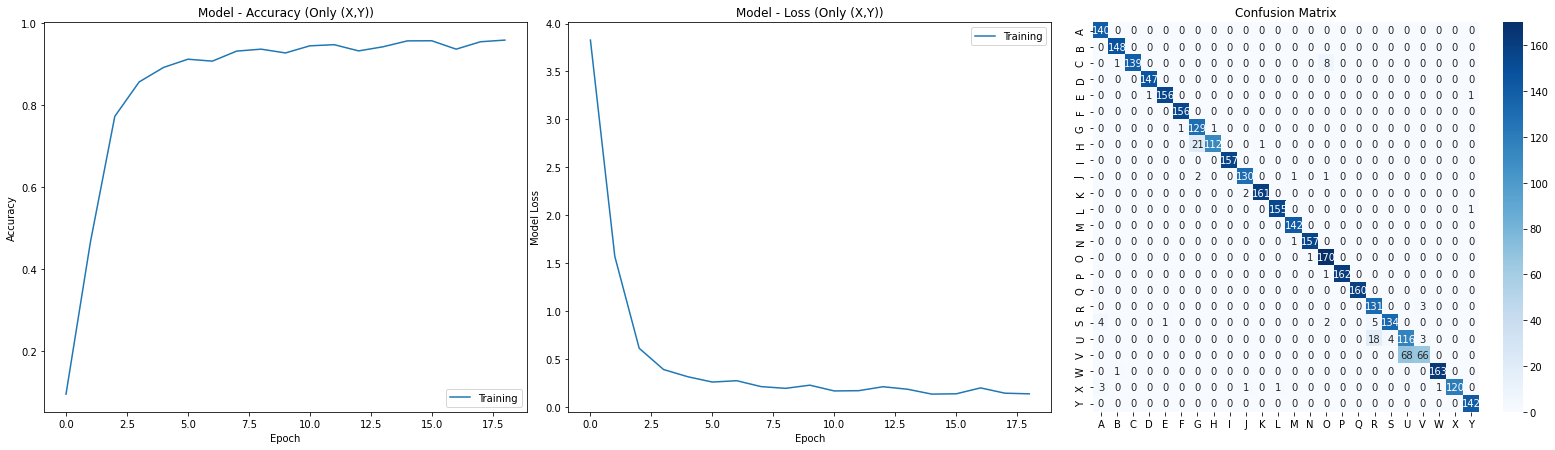


Accuracy: 95.50% 

              precision    recall  f1-score   support

           A       0.95      1.00      0.98       140
           B       0.99      1.00      0.99       148
           C       1.00      0.94      0.97       148
           D       0.99      1.00      1.00       147
           E       0.99      0.99      0.99       158
           F       0.99      1.00      1.00       156
           G       0.85      0.98      0.91       131
           H       0.99      0.84      0.91       134
           I       1.00      1.00      1.00       157
           J       0.98      0.97      0.97       134
           K       0.99      0.99      0.99       163
           L       0.99      0.99      0.99       156
           M       0.99      1.00      0.99       142
           N       0.99      0.99      0.99       158
           O       0.93      0.99      0.96       171
           P       1.00      0.99      1.00       163
           Q       1.00      1.00      1.00       160
       

In [14]:
only_coordinates_results = evaluate_model(history, X_test, y_test, model_xy, "Only (X,Y)", actions)

In [15]:
# with open('data/results.pkl', 'rb') as f:
#     list_of_metrics = pickle.load(f)

# list_of_metrics['only_coordinates'] = only_coordinates_results

# with open('data/results.pkl', 'wb') as f:
#      pickle.dump(list_of_metrics, f)

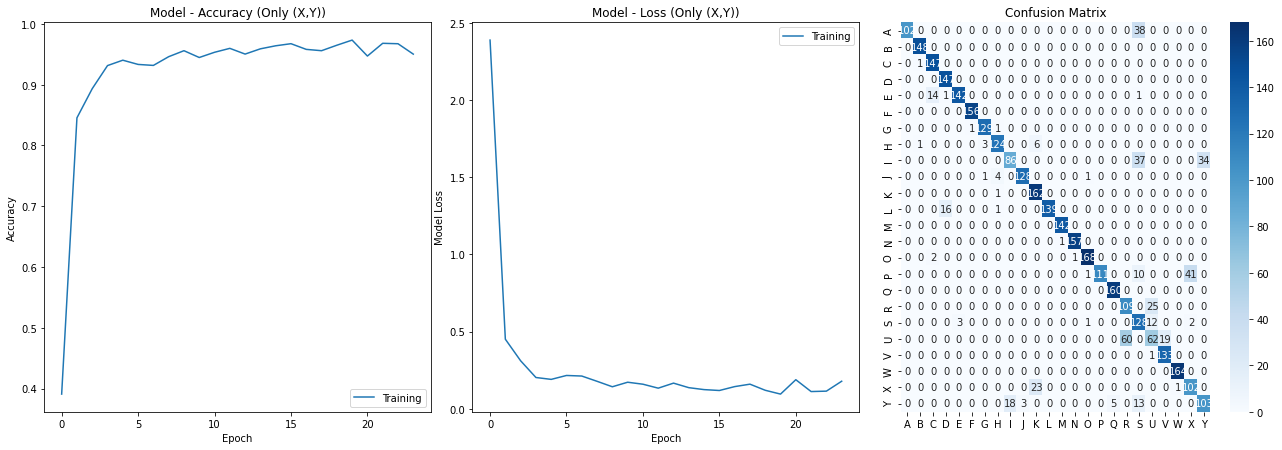


Accuracy: 88.63% 

              precision    recall  f1-score   support

           A       1.00      0.73      0.84       140
           B       0.99      1.00      0.99       148
           C       0.90      0.99      0.95       148
           D       0.90      1.00      0.95       147
           E       0.98      0.90      0.94       158
           F       0.99      1.00      1.00       156
           G       0.97      0.98      0.98       131
           H       0.95      0.93      0.94       134
           I       0.83      0.55      0.66       157
           J       0.98      0.96      0.97       134
           K       0.85      0.99      0.92       163
           L       1.00      0.89      0.94       156
           M       0.99      1.00      1.00       142
           N       0.99      0.99      0.99       158
           O       0.98      0.98      0.98       171
           P       1.00      0.68      0.81       163
           Q       0.97      1.00      0.98       160
       

In [25]:
only_coordinates_results = evaluate_model(history, X_test, y_test, model_xy, "Only (X,Y)", actions)

In [17]:
with open('data/results.pkl', 'rb') as f:
    list_of_metrics = pickle.load(f)

for key in list_of_metrics.keys():
    print(key)

two_angles
only_coordinates


<br>

### **b. Two Angles**

In [9]:
missing = []
data = []
labels = []
mpHands = mp.solutions.hands

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                # print(pkl_path)
                landmarks = []
                for handslms in result:
                    angle_1 = getAngle((handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                                            (handslms.landmark[mpHands.HandLandmark.WRIST].x, handslms.landmark[mpHands.HandLandmark.WRIST].y),
                                            (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y))

                    angle_2 = getAngle((handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y),
                                        (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].y),
                                        (handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].y))
                    # print(angle_1, angle_2)
                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        landmarks.append([lmx, lmy])
                    landmarks.append([angle_1, angle_2])
                    # print(np.array(landmarks).shape)

                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [10]:
print(data.shape, labels.shape)

(17764, 22, 2) (17764,)


In [11]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

Data Shape:  (17764, 22, 2) ||  Label Shape:  (17764,)

Original Label Distribution:
 {0: 747, 1: 748, 2: 746, 3: 748, 4: 749, 5: 749, 6: 605, 7: 718, 8: 748, 9: 746, 10: 749, 11: 749, 12: 750, 13: 749, 14: 749, 15: 748, 16: 731, 17: 748, 18: 750, 19: 745, 20: 746, 21: 748, 22: 749, 23: 749}

Training:
 (14211, 22, 2) (14211, 24) 

Test:
 (3553, 22, 2) (3553, 24) 



In [12]:
model_two_angles, history = train_model( (X_train.shape[1],X_train.shape[2]), y_train.shape[1])

Epoch 1/50
445/445 [==============================] - 2s 3ms/step - loss: 3.7432 - accuracy: 0.0410
Epoch 2/50
445/445 [==============================] - 1s 3ms/step - loss: 3.1662 - accuracy: 0.0436
Epoch 3/50
445/445 [==============================] - 1s 3ms/step - loss: 3.0752 - accuracy: 0.0642
Epoch 4/50
445/445 [==============================] - 1s 3ms/step - loss: 2.8802 - accuracy: 0.1063
Epoch 5/50
445/445 [==============================] - 1s 3ms/step - loss: 1.9460 - accuracy: 0.3352
Epoch 6/50
445/445 [==============================] - 1s 3ms/step - loss: 0.6838 - accuracy: 0.7553
Epoch 7/50
445/445 [==============================] - 1s 3ms/step - loss: 0.3337 - accuracy: 0.8849
Epoch 8/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2174 - accuracy: 0.9296
Epoch 9/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2319 - accuracy: 0.9244
Epoch 10/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1857 - accuracy: 0.9412

In [13]:
model_two_angles.save('./model_saves/two_angles')

INFO:tensorflow:Assets written to: ./model_saves/two_angles\assets


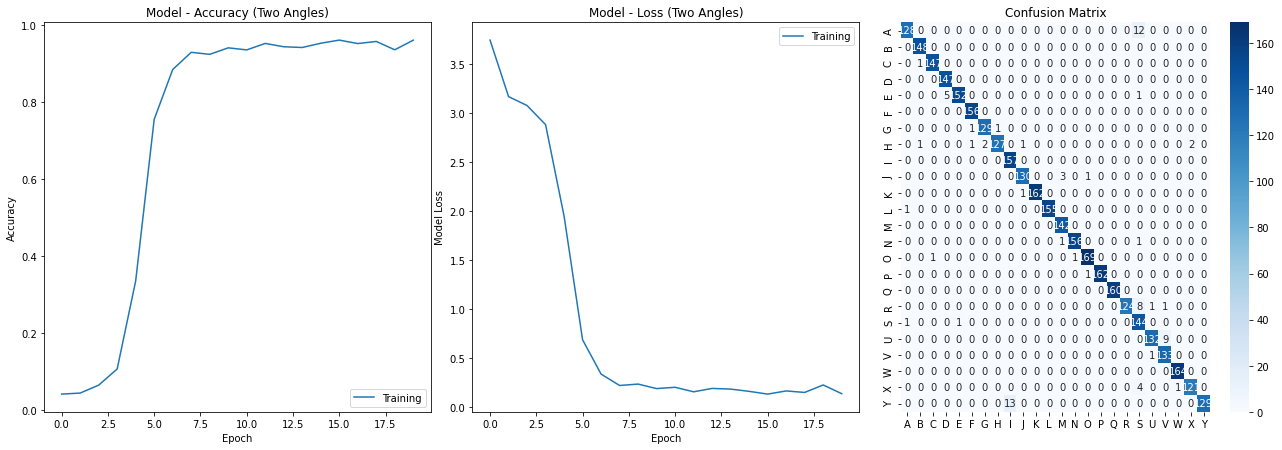


Accuracy: 97.78% 

              precision    recall  f1-score   support

           A       0.98      0.91      0.95       140
           B       0.99      1.00      0.99       148
           C       0.99      0.99      0.99       148
           D       0.97      1.00      0.98       147
           E       0.99      0.96      0.98       158
           F       0.99      1.00      0.99       156
           G       0.98      0.98      0.98       131
           H       0.99      0.95      0.97       134
           I       0.92      1.00      0.96       157
           J       0.98      0.97      0.98       134
           K       1.00      0.99      1.00       163
           L       1.00      0.99      1.00       156
           M       0.97      1.00      0.99       142
           N       0.99      0.99      0.99       158
           O       0.99      0.99      0.99       171
           P       1.00      0.99      1.00       163
           Q       1.00      1.00      1.00       160
       

In [14]:
two_angles_results = evaluate_model(history, X_test, y_test, model_two_angles, "Two Angles", actions)

In [17]:
list_of_metrics['two_angles'] = two_angles_results

In [19]:
with open('data/results.pkl','wb') as f:
    pickle.dump(list_of_metrics, f)

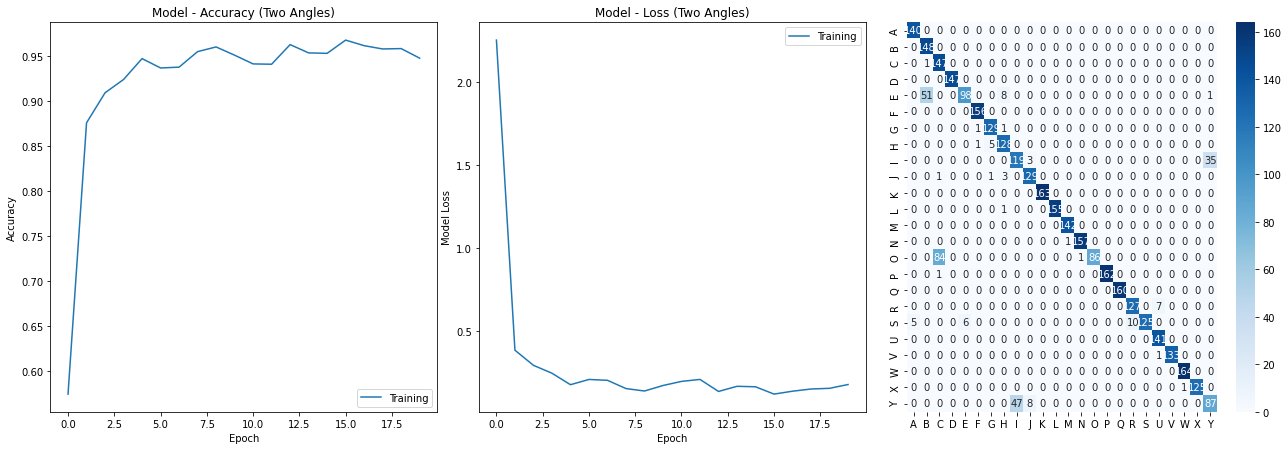


Accuracy: 91.98% 

              precision    recall  f1-score   support

           A       0.97      1.00      0.98       140
           B       0.74      1.00      0.85       148
           C       0.63      0.99      0.77       148
           D       1.00      1.00      1.00       147
           E       0.94      0.62      0.75       158
           F       0.99      1.00      0.99       156
           G       0.96      0.98      0.97       131
           H       0.91      0.96      0.93       134
           I       0.72      0.76      0.74       157
           J       0.92      0.96      0.94       134
           K       1.00      1.00      1.00       163
           L       1.00      0.99      1.00       156
           M       0.99      1.00      1.00       142
           N       0.99      0.99      0.99       158
           O       1.00      0.50      0.67       171
           P       1.00      0.99      1.00       163
           Q       1.00      1.00      1.00       160
       

In [25]:
two_angles_results = evaluate_model(history, X_test, y_test, model_two_angles, "Two Angles", actions)

<br>

### **c. Distance + Angles**

In [9]:
missing = []
data = []
labels = []
mpHands = mp.solutions.hands

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                # print(pkl_path)
                landmarks = []
                for handslms in result:
                    angle_1 = getAngle((handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                                            (handslms.landmark[mpHands.HandLandmark.WRIST].x, handslms.landmark[mpHands.HandLandmark.WRIST].y),
                                            (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y))

                    angle_2 = getAngle((handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y),
                                        (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].y),
                                        (handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].y))
                    
                    
                    distance_1 = get_distance( (handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                                                (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y) )
                    
                    distance_2 = get_distance( (handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                                                (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y) )

                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        landmarks.append([lmx, lmy])
                    landmarks.append([angle_1, angle_2])
                    landmarks.append([distance_1, distance_2])
                    # print(np.array(landmarks).shape)

                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [10]:
print(data.shape, labels.shape)

(17764, 23, 2) (17764,)


In [11]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

Data Shape:  (17764, 23, 2) ||  Label Shape:  (17764,)

Original Label Distribution:
 {0: 747, 1: 748, 2: 746, 3: 748, 4: 749, 5: 749, 6: 605, 7: 718, 8: 748, 9: 746, 10: 749, 11: 749, 12: 750, 13: 749, 14: 749, 15: 748, 16: 731, 17: 748, 18: 750, 19: 745, 20: 746, 21: 748, 22: 749, 23: 749}

Training:
 (14211, 23, 2) (14211, 24) 

Test:
 (3553, 23, 2) (3553, 24) 



In [12]:
model_angle_and_distance, history = train_model( (X_train.shape[1],X_train.shape[2]), y_train.shape[1])

Epoch 1/50
445/445 [==============================] - 2s 3ms/step - loss: 2.5659 - accuracy: 0.4175
Epoch 2/50
445/445 [==============================] - 1s 3ms/step - loss: 0.4117 - accuracy: 0.8690
Epoch 3/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2414 - accuracy: 0.9260
Epoch 4/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2027 - accuracy: 0.9401
Epoch 5/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2070 - accuracy: 0.9378
Epoch 6/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1669 - accuracy: 0.9510
Epoch 7/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1835 - accuracy: 0.9478
Epoch 8/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1529 - accuracy: 0.9576
Epoch 9/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1657 - accuracy: 0.9515
Epoch 10/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1165 - accuracy: 0.9665

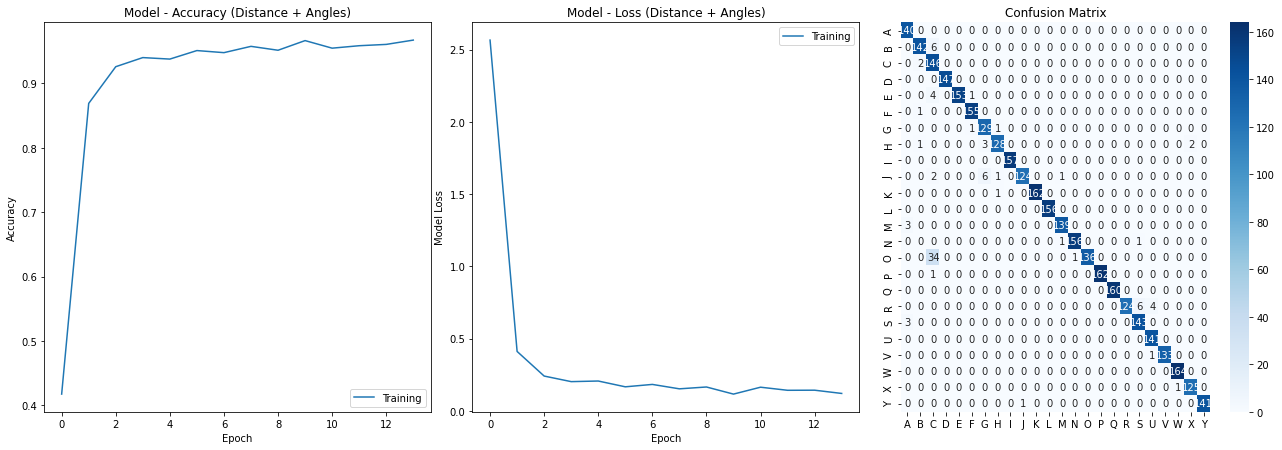


Accuracy: 97.47% 

              precision    recall  f1-score   support

           A       0.96      1.00      0.98       140
           B       0.97      0.96      0.97       148
           C       0.76      0.99      0.86       148
           D       1.00      1.00      1.00       147
           E       1.00      0.97      0.98       158
           F       0.99      0.99      0.99       156
           G       0.93      0.98      0.96       131
           H       0.98      0.96      0.97       134
           I       1.00      1.00      1.00       157
           J       0.99      0.93      0.96       134
           K       1.00      0.99      1.00       163
           L       1.00      1.00      1.00       156
           M       0.99      0.98      0.98       142
           N       0.99      0.99      0.99       158
           O       1.00      0.80      0.89       171
           P       1.00      0.99      1.00       163
           Q       1.00      1.00      1.00       160
       

In [13]:
angle_and_distance_results = evaluate_model(history, X_test, y_test, model_angle_and_distance, "Distance + Angles", actions)

In [14]:
with open('data/results.pkl', 'rb') as f:
    list_of_metrics = pickle.load(f)

list_of_metrics['angle+distance'] = angle_and_distance_results

with open('data/results.pkl', 'wb') as f:
     pickle.dump(list_of_metrics, f)

<br>

---

## **Results**

In [24]:
print(actions)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y']


In [34]:
with open('data/results.pkl', 'rb') as f:
    list_of_metrics = pickle.load(f)

for key in list_of_metrics.keys():
    print(key)

two_angles
only_coordinates
angle+distance


In [45]:
results = {}

for method in list_of_metrics.keys():

    alpha_results = {}
    metrics = list_of_metrics[method]['metrics']
    
    for key,value in metrics.items():
        if key in actions:
            alpha_results[key] = {'precision':round(value['precision'], 3), 'f1':round(value['f1-score'], 3), 'recall':round(value['recall'], 3)} 
        
        elif key=='accuracy':
            accuracy = value
        elif key=='weighted avg':
            results[method] = {"Accuracy": accuracy, "F1": round(value['f1-score'],3), "Sub-Scores": alpha_results}

for (key, value) in results.items(): 
    print(key, ":\n", "Accuracy: ", value["Accuracy"], "\n F1: ", value["F1"], "\n Sub-Scores: ")
    for k,v in value["Sub-Scores"].items():
            print("\t", k, ": ", v)
    print("\n\n")

two_angles :
 Accuracy:  0.9777652687869406 
 F1:  0.978 
 Sub-Scores: 
	 A :  {'precision': 0.985, 'f1': 0.948, 'recall': 0.914}
	 B :  {'precision': 0.987, 'f1': 0.993, 'recall': 1.0}
	 C :  {'precision': 0.993, 'f1': 0.993, 'recall': 0.993}
	 D :  {'precision': 0.967, 'f1': 0.983, 'recall': 1.0}
	 E :  {'precision': 0.993, 'f1': 0.977, 'recall': 0.962}
	 F :  {'precision': 0.987, 'f1': 0.994, 'recall': 1.0}
	 G :  {'precision': 0.985, 'f1': 0.985, 'recall': 0.985}
	 H :  {'precision': 0.992, 'f1': 0.969, 'recall': 0.948}
	 I :  {'precision': 0.924, 'f1': 0.96, 'recall': 1.0}
	 J :  {'precision': 0.985, 'f1': 0.977, 'recall': 0.97}
	 K :  {'precision': 1.0, 'f1': 0.997, 'recall': 0.994}
	 L :  {'precision': 1.0, 'f1': 0.997, 'recall': 0.994}
	 M :  {'precision': 0.973, 'f1': 0.986, 'recall': 1.0}
	 N :  {'precision': 0.994, 'f1': 0.99, 'recall': 0.987}
	 O :  {'precision': 0.988, 'f1': 0.988, 'recall': 0.988}
	 P :  {'precision': 1.0, 'f1': 0.997, 'recall': 0.994}
	 Q :  {'precision'